# Tracking

This notebook partially covers the following modules:
* `tramway.analyzer.images`
* `tramway.analyzer.tracker`

**TRamWAy** features a single [tracking algorithm](#Tracking) to identify trajectories among localization data points.

As locations and trajectories correspond to objects in the localization microscopy images, this notebook also shows how to visualize both types of data, generating movies (see [1](#Movie-with-overlaid-locations) and [2](#Resulting-movie-with-overlaid-trajectories)).

In [1]:
from src.tracking import set_notebook_theme, get_tif_file

# this actually does nothing for *light* themes,
# and makes a few color adjustements in plots for *dark* themes if requested:
set_notebook_theme('light')

# the image file is not fetched on install;
# it is shipped separately because of its size, while only the current document needs it:
get_tif_file()

from matplotlib import pyplot as plt

## Previewing

Prior to tracking localization microscopy data, one may want to confront the localization data with the raw images, if available.

To do so, we first need to register the images with the location coordinate system, adjusting the offset in pixels.

### Offset adjustment


In [2]:
from tramway.analyzer import *
import numpy as np

a = RWAnalyzer()

a.images = images.from_tiff_file('../data/Image_8bit.tif')
a.images.pixel_size = .155 # in µm

a.spt_data = spt_data.from_ascii_file('../data/Image_loc.txt')
a.spt_data.frame_interval = dt = .04 # in s
a.spt_data.localization_precision = .02 # in µm

Note that we load the localization data into an attribute called `spt_data`, while SPT stands for *single particle tracking*.
The `RWAnalyzer` object does not provide distinct attributes for non-tracked and tracked localization data.

In [3]:
image = a.images
loc_data = a.spt_data.dataframe
loc_data

,x,y,t
0,23.7709,9.4375,0.04
1,24.4957,9.3594,0.04
2,27.9041,44.2310,0.04
3,7.8802,17.3183,0.04
4,8.1629,38.3049,0.04
...,...,...,...
568624,10.3772,28.2495,481.96
568625,25.8403,4.8127,481.96
568626,18.7320,36.1600,481.96
568627,7.9930,10.0694,481.96


`'x'` and `'y'` are spatial coordinates (here in µm), and `'t'` encodes time (here in seconds).

If we overlay the locations for the first frame (at ``t=0.04``) onto the first frame, without any offset correction:

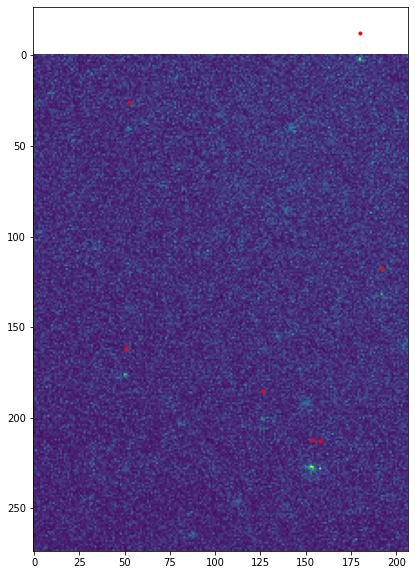

In [4]:
fig = plt.figure(figsize=(10, 10))
# plot the first frame
plt.imshow(image.stack[0], figure=fig)
# overlay the corresponding locations
a.images.mpl.plot(loc_data[loc_data['t']==dt], 'r.');

We observe a clear offset along the ordinates.

Let us adjust the offset and draw again.

In [5]:
image.loc_offset = np.r_[0, 15] # in pixels, for x (abscissa) and y (ordinates)

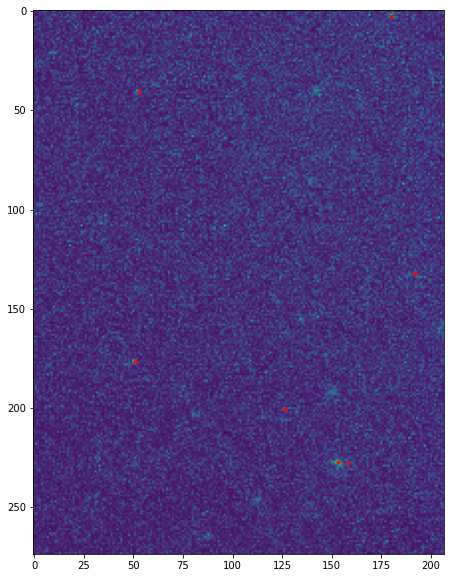

In [6]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(image.stack[0], figure=fig)
a.images.mpl.plot(loc_data[loc_data['t']==dt], 'r.');

### Working on a region of interest

To zoom in and check multiple frames, we define a region of interest.
For ROI-definition utilities, see the [roi.ipynb notebook](roi.md).

In [7]:
# bounding box for space coordinates (x, y)

center = np.array([[17.3619, 19.2112]]) # 1x2 array for a single ROI
side = 2.5

a.roi = roi.from_squares(center, side)

# bounding box for time

t0, t1 = 298.44, 305.16

In [8]:
# location data in the ROI
r = single(a.roi)
cropped_loc = r.crop(loc_data)

In [9]:
# image frames cropped at the ROI
frames = []
for t, frame in r.crop_frames(return_time=True):
    if t0<=t and t<=t1:
        frames.append((t, frame))

In [10]:
# coordinates of the bottom left pixel of the cropped frames
origin, _ = image.cropping_bounds(r.bounding_box)

As an example, we can plot the first frame in the defined time interval:

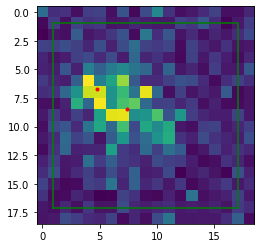

In [11]:
t, frame = frames[0]

xy = cropped_loc[cropped_loc['t']==t]

plt.imshow(frame)
a.images.mpl.plot(xy['x'], xy['y'], 'r.', frame=frame, origin=origin)

xy0, xy1 = r.bounding_box
roi_contour_x = np.r_[xy0[0], xy0[0], xy1[0], xy1[0], xy0[0]]
roi_contour_y = np.r_[xy0[1], xy1[1], xy1[1], xy0[1], xy0[1]]

a.images.mpl.plot(roi_contour_x, roi_contour_y, 'g-', frame=frame, origin=origin);

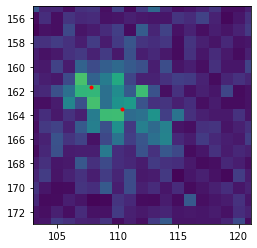

In [12]:
# alternative code that draws the entire frame and zooms in,
# keeping the original x and y coordinates and color scale
plt.imshow(image.stack[int(np.round(t / dt)) - 1])
a.images.mpl.plot(loc_data[loc_data['t']==t], 'r.')
lb, ub = image.cropping_bounds(r.bounding_box)
xl, yl = np.r_[lb[0], ub[0]], np.r_[lb[1], ub[1]]
xl = xl / image.pixel_size - image.loc_offset[0]
yl = image.height - 1 - (yl / image.pixel_size - image.loc_offset[1])
plt.xlim(xl)
plt.ylim(yl);

### Movie with overlaid locations

To visualize all the frames, the `images` attribute features a method that generates a movie.

In [13]:
a.images.to_color_movie(output_file='locations_only.webm',
                     frames=frames, origin=origin, locations=cropped_loc,
                     magnification='2x', markersize=4, playback_rate=.2)

In [14]:
from IPython.display import Video
Video('locations_only.webm')

The image pixels are magnified and the time is slowed down, using arguments `magnification` and `playback_rate` respectively.

While such zoomed-in images may give another opportunity to better adjust the coordinate offset (half a pixel is a common additional offset),
we will instead focus on tracking and illustrate the resulting trajectories with a similar movie.

## The *non-tracking* tracker

**TRamWAy** features a single tracking algorithm, referred to as the *non-tracking* tracker.
The underlying method was designed for estimating the dynamics in a Bayesian way, considering many possible matching instead of the most likely tracks, hence the awkward name.

For actual tracking purposes, it is based on the Kuhn-Munkres algorithm and requires to be given a hint about how high the diffusivity is expected to be.

Let us make a new `RWAnalyzer` object:

In [15]:
a = RWAnalyzer()

a.tracker = tracker.from_non_tracking()
a.tracker.frame_interval = dt = .04 # in s
a.tracker.localization_precision = .02 # in µm
a.tracker.estimated_high_diffusivity = .3 # in µm²/s

a.tracker.track('../data/Image_loc.txt', register=True)

,n,x,y,t
0,1,23.7709,9.4375,0.04
1,1,23.7278,9.2960,0.08
2,1,23.7237,9.3321,0.12
3,1,23.7337,9.3320,0.16
4,1,23.7197,9.3918,0.20
...,...,...,...,...
459376,77324,16.7185,33.2227,481.96
459377,77325,18.3156,16.3458,481.92
459378,77325,18.2613,16.3665,481.96
459379,77326,20.2891,24.3668,481.92


Compared to the localization data, a column named `'n'` was appended. This column gives the trajectory index.

The ``register=True`` argument updates the `spt_data` attribute so that it accommodates the resulting tracked data.
That is why we started over with a new `RWAnalyzer` object and a fresh `spt_data` attribute.

In [16]:
trajectories = first(a.spt_data).dataframe
trajectories.head(3)

,n,x,y,t
0,1,23.7709,9.4375,0.04
1,1,23.7278,9.2960,0.08
2,1,23.7237,9.3321,0.12


In combination with tracking, the `spt_data` attribute should be iterated because it may contain multiple datasets.
Indeed, the `track` method can be called multiple times, to track different data files.
For convenience, the `first` function consumes the iterator and returns the first dataset - in this case the only dataset (another suitable function similar to `first` is `single`).

### SPT data export

The trajectory data can be saved in a file:

In [17]:
for data in a.spt_data:
    data.to_ascii_file('../data/Image_traj.txt')
    break
# same as first(a.spt_data).to_ascii_file(...)

### Movie generation

We can now extract the cropped frames and trajectories to generate a movie for the same ROI as previously.

In [18]:
a.roi = roi.from_squares(center, side)
r = single(a.roi)
cropped_translocations = r.crop(trajectories)

As explained [elsewhere](roi.md), `crop` yields translocations, not to be confused with trajectories.
To visualize the trajectories, we need to convert the translocations.

In [19]:
from tramway.core import translocations_to_trajectories
cropped_traj = translocations_to_trajectories(cropped_translocations)

Although `frames` and `origin` are already defined, we need the `images` attribute to be properly initialized.

In [20]:
a.images = images.from_tiff_file('../data/Image_8bit.tif')
a.images.pixel_size = .155 # in µm
a.images.loc_offset = np.r_[0, 15] # in pixels (coordinates x and y)

a.images.to_color_movie(output_file='trajectories.webm',
                        frames=frames, origin=origin, locations=cropped_loc,
                        trajectories=cropped_traj,
                        magnification='2x', markersize=3, playback_rate=.2)

Note that we set a same `loc_offset` for all the image stacks because we actually have a single files.
Different image files may exhibit different offsets, and we would rather loop over `a.images` to set `loc_offset` on a per-image basis.

#### Resulting movie with overlaid trajectories

In [21]:
from IPython.display import Video
Video('trajectories.webm')

The `locations` argument is optional. If omitted, the trajectory heads in red do not appear.

#### Full movie generation code

To sum up, the above movie can be generated directly from the *Image_traj.txt* SPT data file with the code below, all imports included:

In [22]:
%%script echo skipping

from tramway.analyzer import *
from tramway.core import translocations_to_trajectories
import numpy as np

a = RWAnalyzer()

## 1. define the data location and global parameters

a.images = images.from_tiff_file('../data/Image_8bit.tif')
a.images.pixel_size = .155 # in µm
a.images.loc_offset = np.r_[0, 15] # in pixels (coordinates x and y)

a.spt_data = spt_data.from_ascii_file('../data/Image_traj.txt')
a.spt_data.frame_interval = .04 # in s
a.spt_data.localization_precision = .02 # in µm

## 2. specify a region of interest for visualization

# bounding box for space coordinates (x, y)
center = np.array([[17.3619, 19.2112]]) # 1x2 array for a single ROI
side = 2.5
# bounding box for time
t0, t1 = 298.44, 305.16

a.roi = roi.from_squares(center, side)

## 3. get the data in the ROI

r = single(a.roi)
origin, _ = a.images.cropping_bounds(r.bounding_box)
cropped_transloc = r.crop() # `crop` knows where to find the trajectory data to be cropped
cropped_traj = cropped_loc = translocations_to_trajectories(cropped_transloc)

frames = []
for t, frame in r.crop_frames(return_time=True):
    if t0<=t and t<=t1:
        frames.append((t, frame))

## 4. generate a movie

a.images.to_color_movie(output_file='trajectories.webm',
                        frames=frames, origin=origin, locations=cropped_loc,
                        trajectories=cropped_traj,
                        magnification='2x', markersize=3, playback_rate=.2)

skipping
